In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

In [2]:
base_path = '/home/jim/Documents/AI/fact/reproduction/'
sys.path.insert(0, base_path)
from Model import *

In [3]:
model = Model.Initialize('vae', None, pretrained_path=f'{base_path}Models/scvis_heart.pt')

Loading the pretrained model...


In [5]:
# sys.path.insert(0, "../Code/")
# from load_scvis import load_vae

exp_path = f'{base_path}/ELDR/Heart/'
data_path = f'{exp_path}Data/'

data_file = data_path + 'X.tsv'
target_file = data_path + 'y.tsv'
input_dim = 13
#model_file = "Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt"

x = pd.read_csv(data_file, sep="\t").values
y = pd.read_csv(target_file, sep="\t").values



data_rep = model.Encode(x)

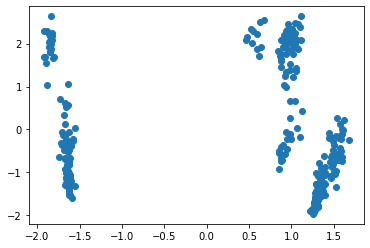

In [6]:
plt.scatter(data_rep[:,0], data_rep[:,1])
plt.show()

In [7]:
from sklearn.cluster import KMeans

num_clusters = 4
kmeans = KMeans(n_clusters = num_clusters, random_state=0).fit(data_rep)

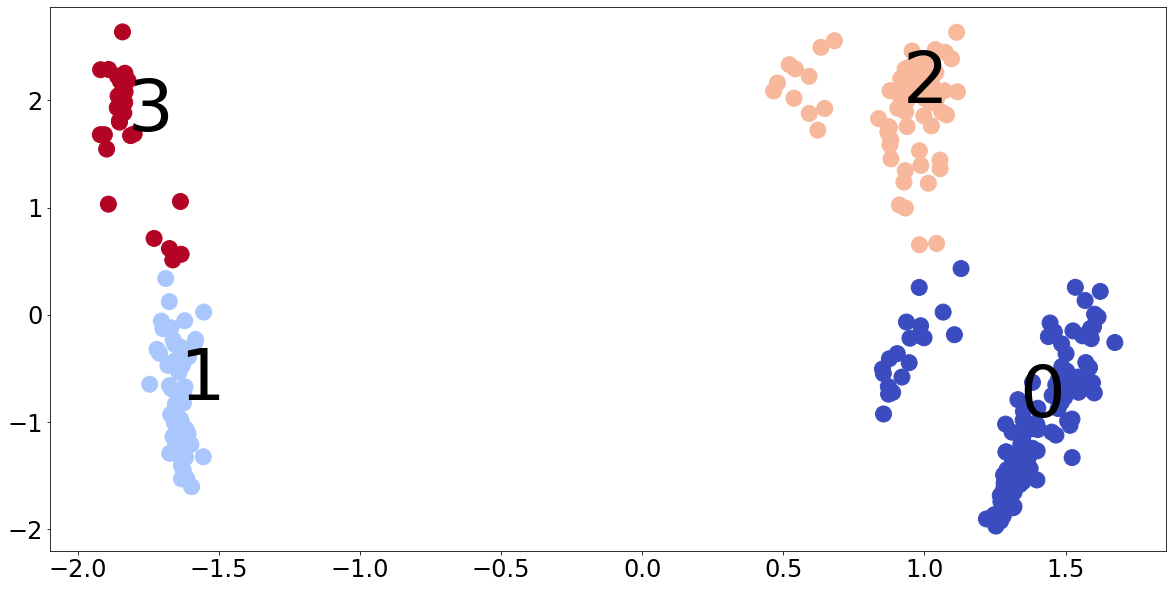

In [8]:
from eldr.plotter.myplot import *
means, centers, indices = plot_groups(x, data_rep.numpy(), num_clusters, kmeans.labels_, name = "./synth-rep.png")

In [10]:
from eldr.explain.explain_cs import *
epsilon = 0

Explainer = Explain(model, means, centers, use_scaling=True)

# if True:
#     print(Explainer.eval_epsilon(torch.tensor(x), indices, epsilon))

epsilons = np.linspace(0, 2.0, num=100).tolist()
for iter_epsilon in epsilons:
    mean_, min_, max_ = Explainer.eval_epsilon(torch.tensor(x), indices, iter_epsilon)
    if mean_ >= 0.95 and min_ >= 0.95 and max_>= 0.95:
        epsilon = iter_epsilon
        break
print(epsilon)

0.26262626262626265


In [11]:
results_path = f'{base_path}experiments/Heart_scaling/deltas/'
K = [1, 3, 5, 7, 9, 11, 13]

[[-0.0014046  -0.9763636  -0.00043318 -0.00058125 -0.00026103 -0.00070434
   0.00030955  0.0001201  -0.04368584 -0.00101453  0.00130562 -0.00054814
  -0.00120972]
 [ 0.0052468   0.04058382 -0.00230507  0.00226456  0.00101789  0.00782179
  -0.00149696 -0.00790972  1.2292162   0.00942708 -0.01082106  0.00539285
   0.00583229]
 [ 0.00177726 -0.95006806 -0.0000261   0.00125805 -0.00109272  0.00694321
  -0.0008535  -0.005494    1.1636666   0.00948645 -0.01471145  0.00442977
   0.00511395]]
[[-0.00131039 -0.00113565  0.00030257  0.00018207  0.00096258  0.0000321
  -0.00023043 -0.00010369 -0.00102947  0.00066351  0.00139105 -0.00088109
  -0.00011648]
 [ 0.00160836  0.00579196 -0.00023993  0.00031315  0.00075364 -0.00078748
  -0.00057695 -0.00180579  0.37726256 -0.00033181 -0.00495638  0.00150401
   0.00554681]
 [ 0.00066753  0.00085772  0.00037326  0.00074063 -0.00042878  0.00075328
  -0.00116588 -0.00185217  0.47283545  0.00074014 -0.00108595  0.00049504
   0.00155926]]


/home/jim/Documents/AI/fact/reproduction/eldr/plotter/myplot.py:106: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)
/home/jim/anaconda3/envs/factai/lib/python3.8/site-packages/mpl_toolkits/axes_grid1/axes_grid.py:46: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


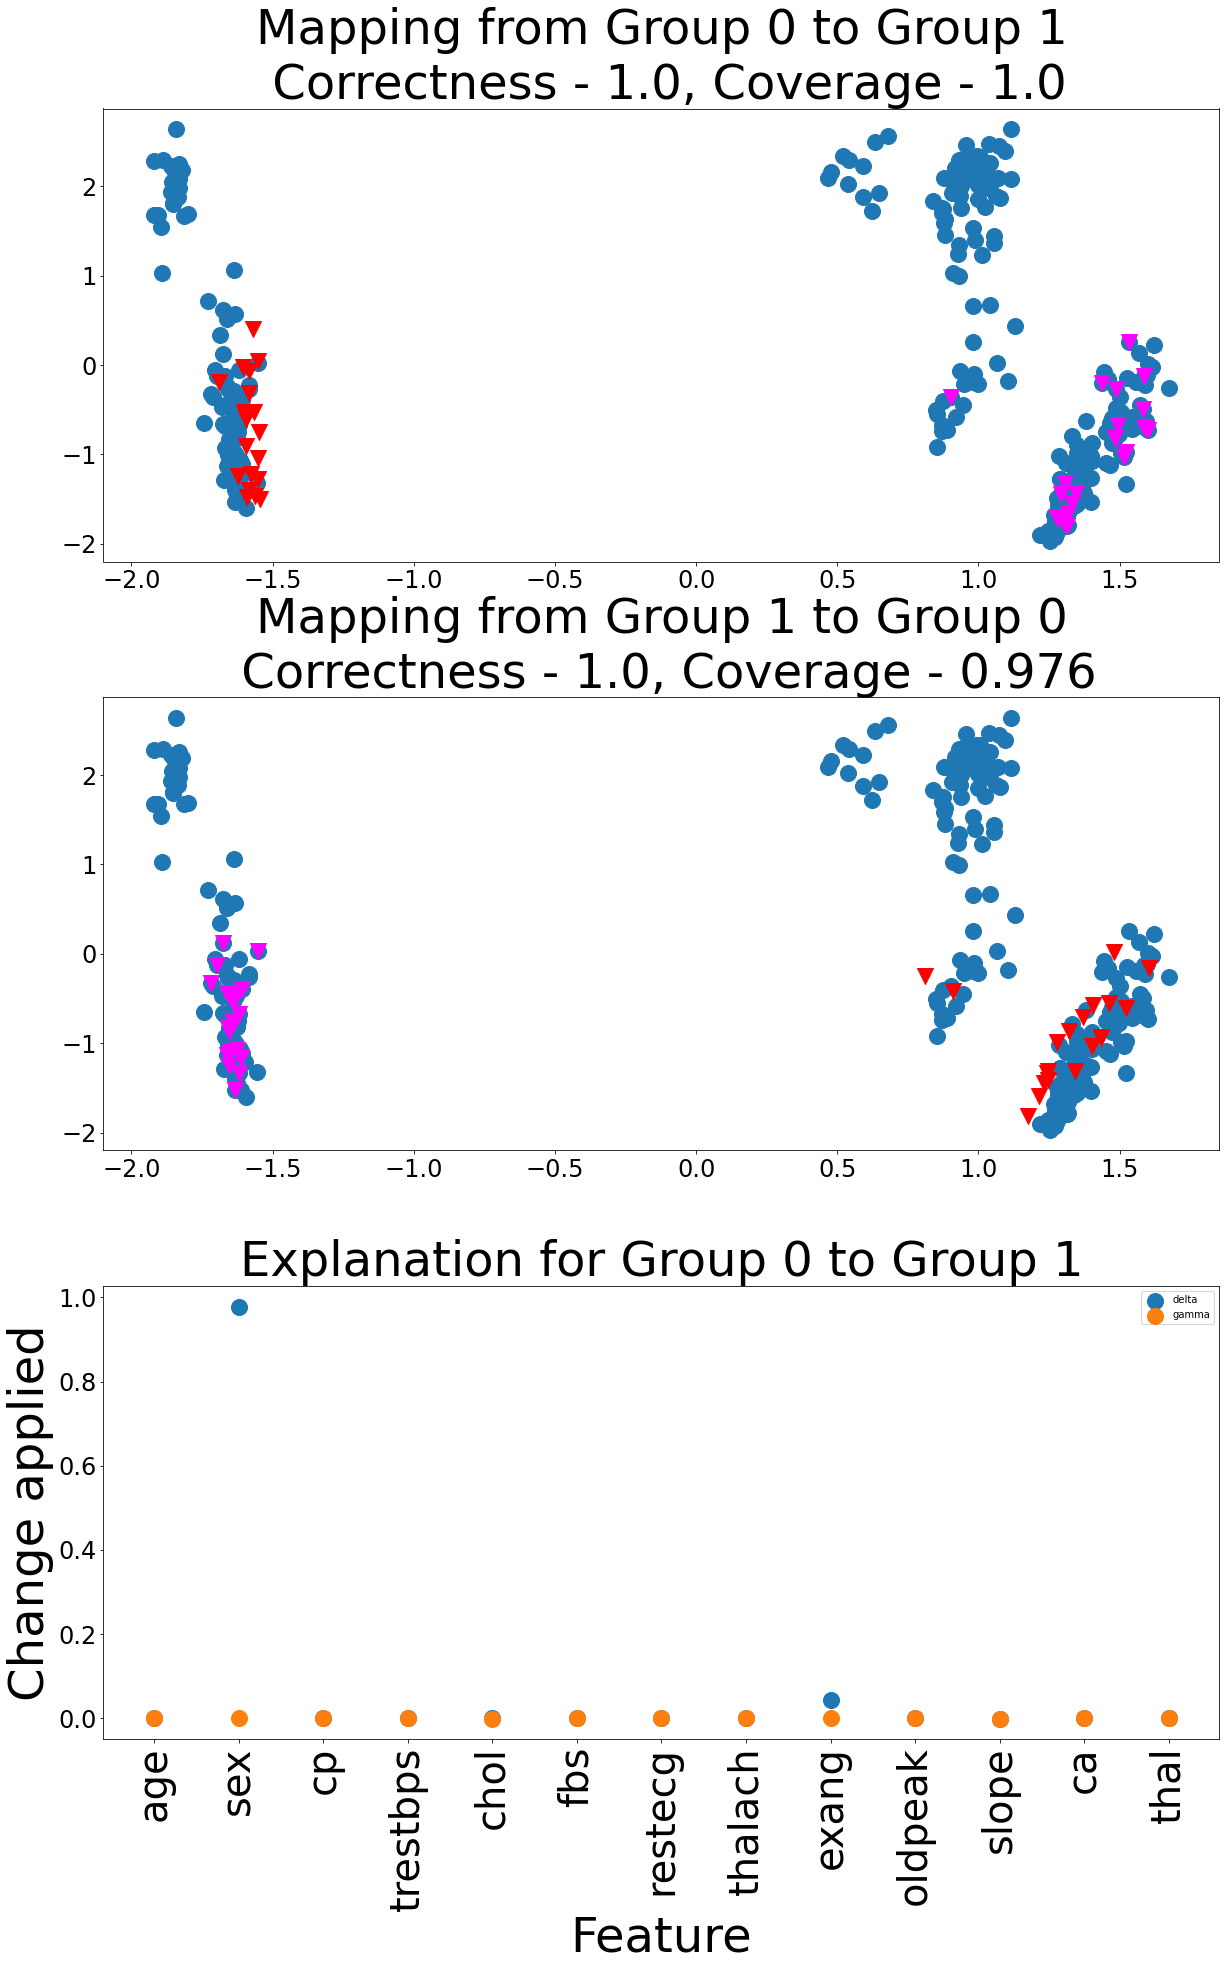

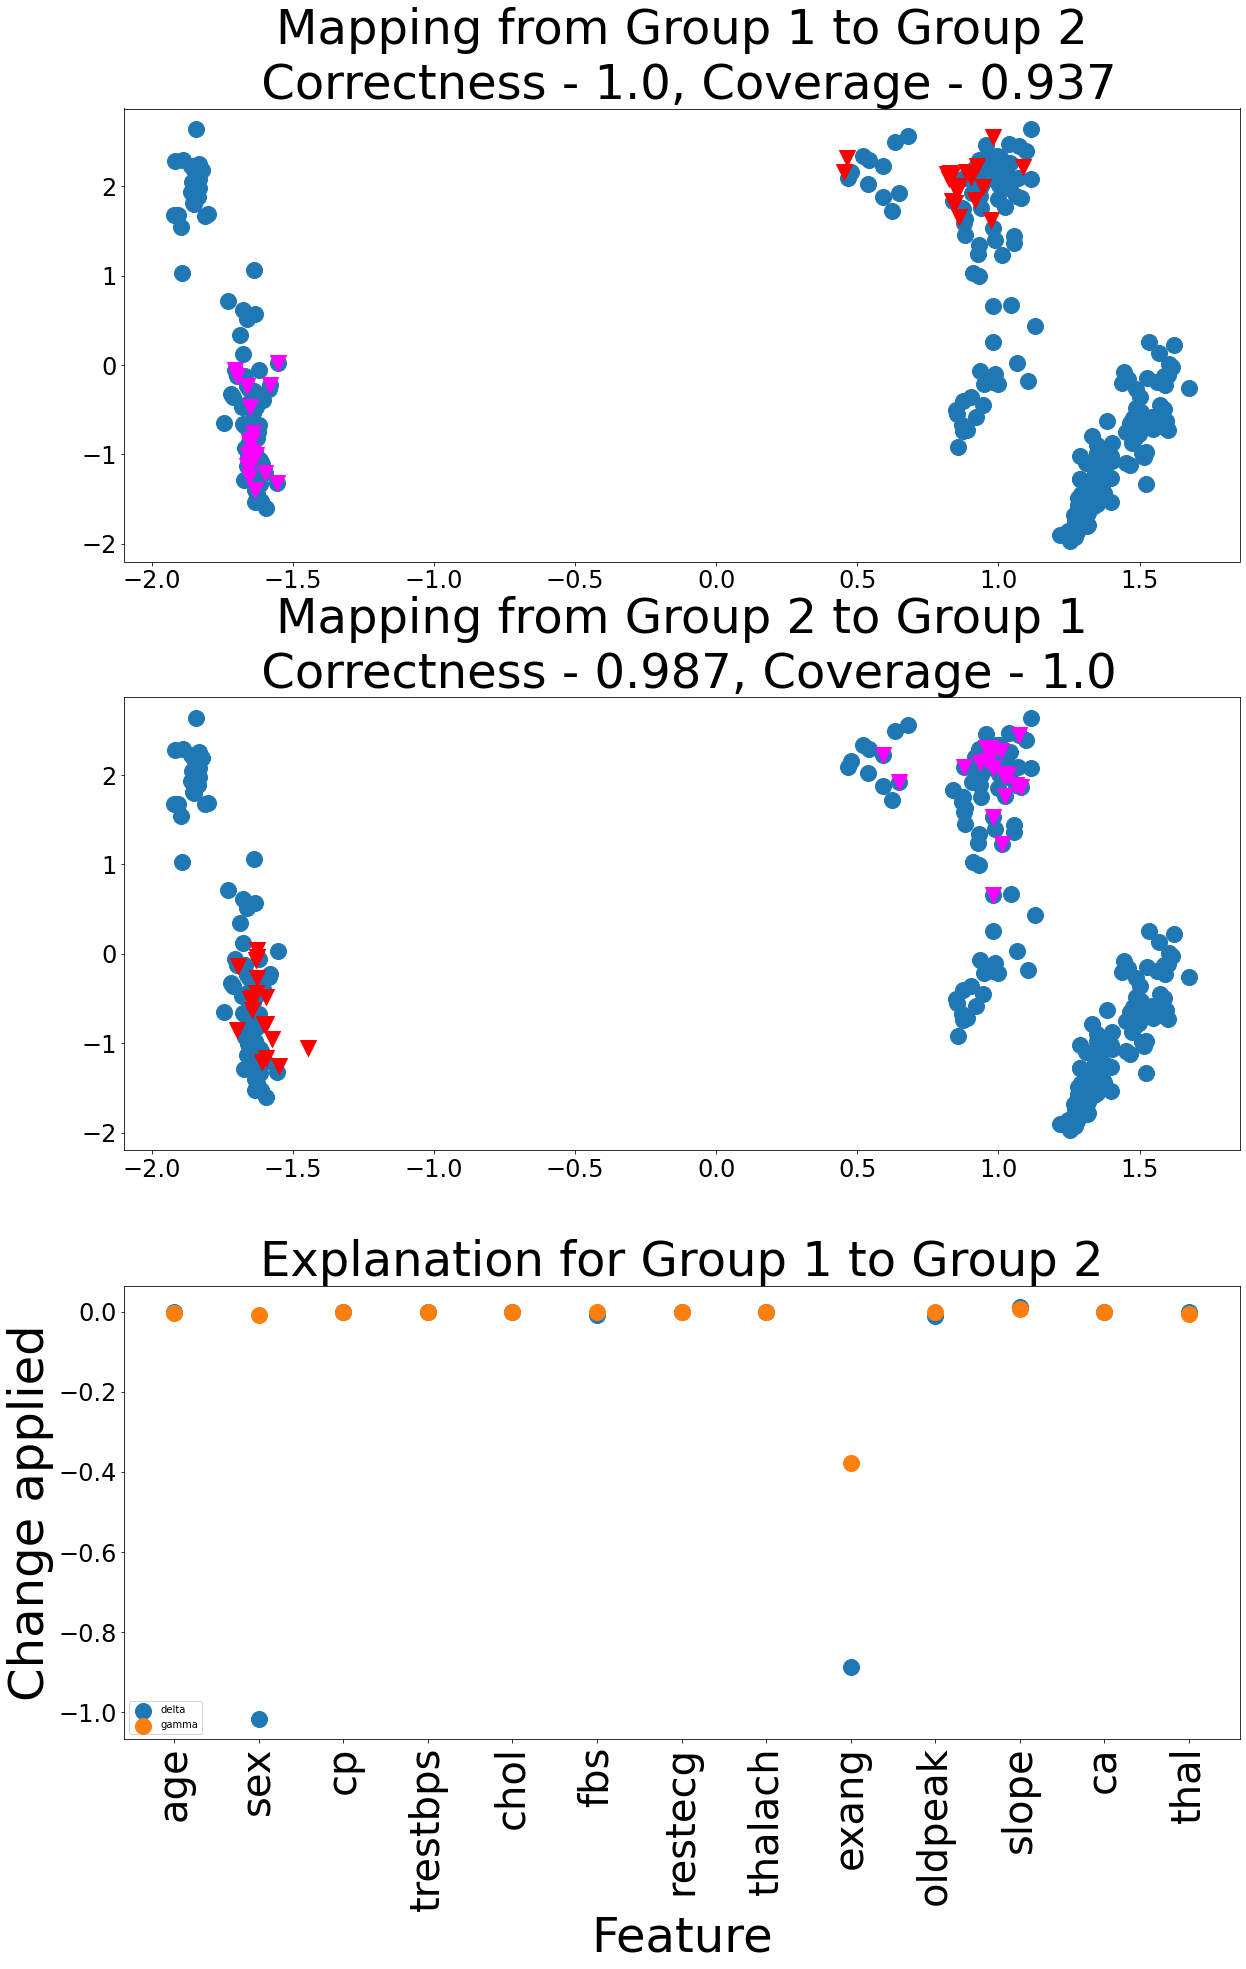

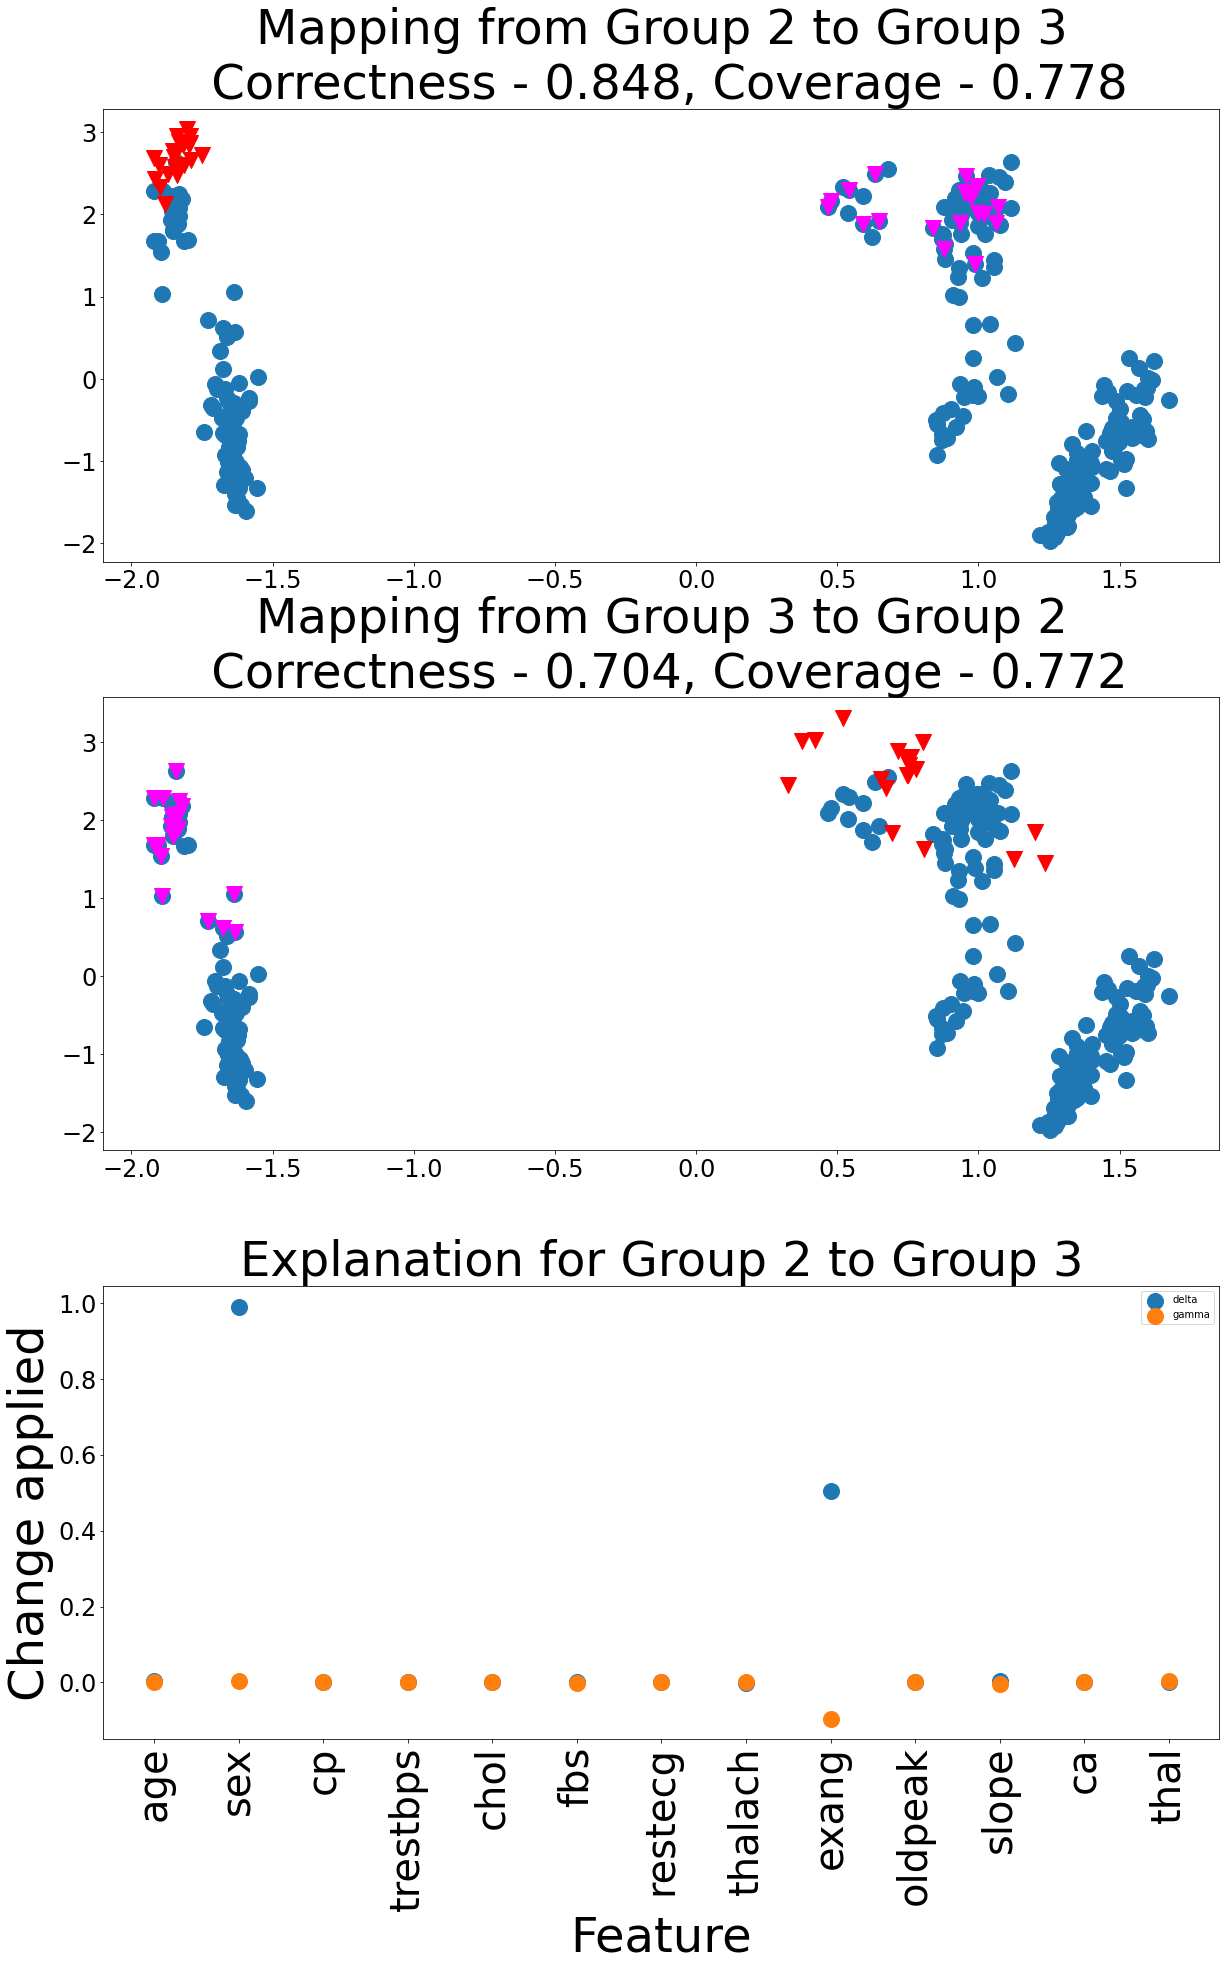

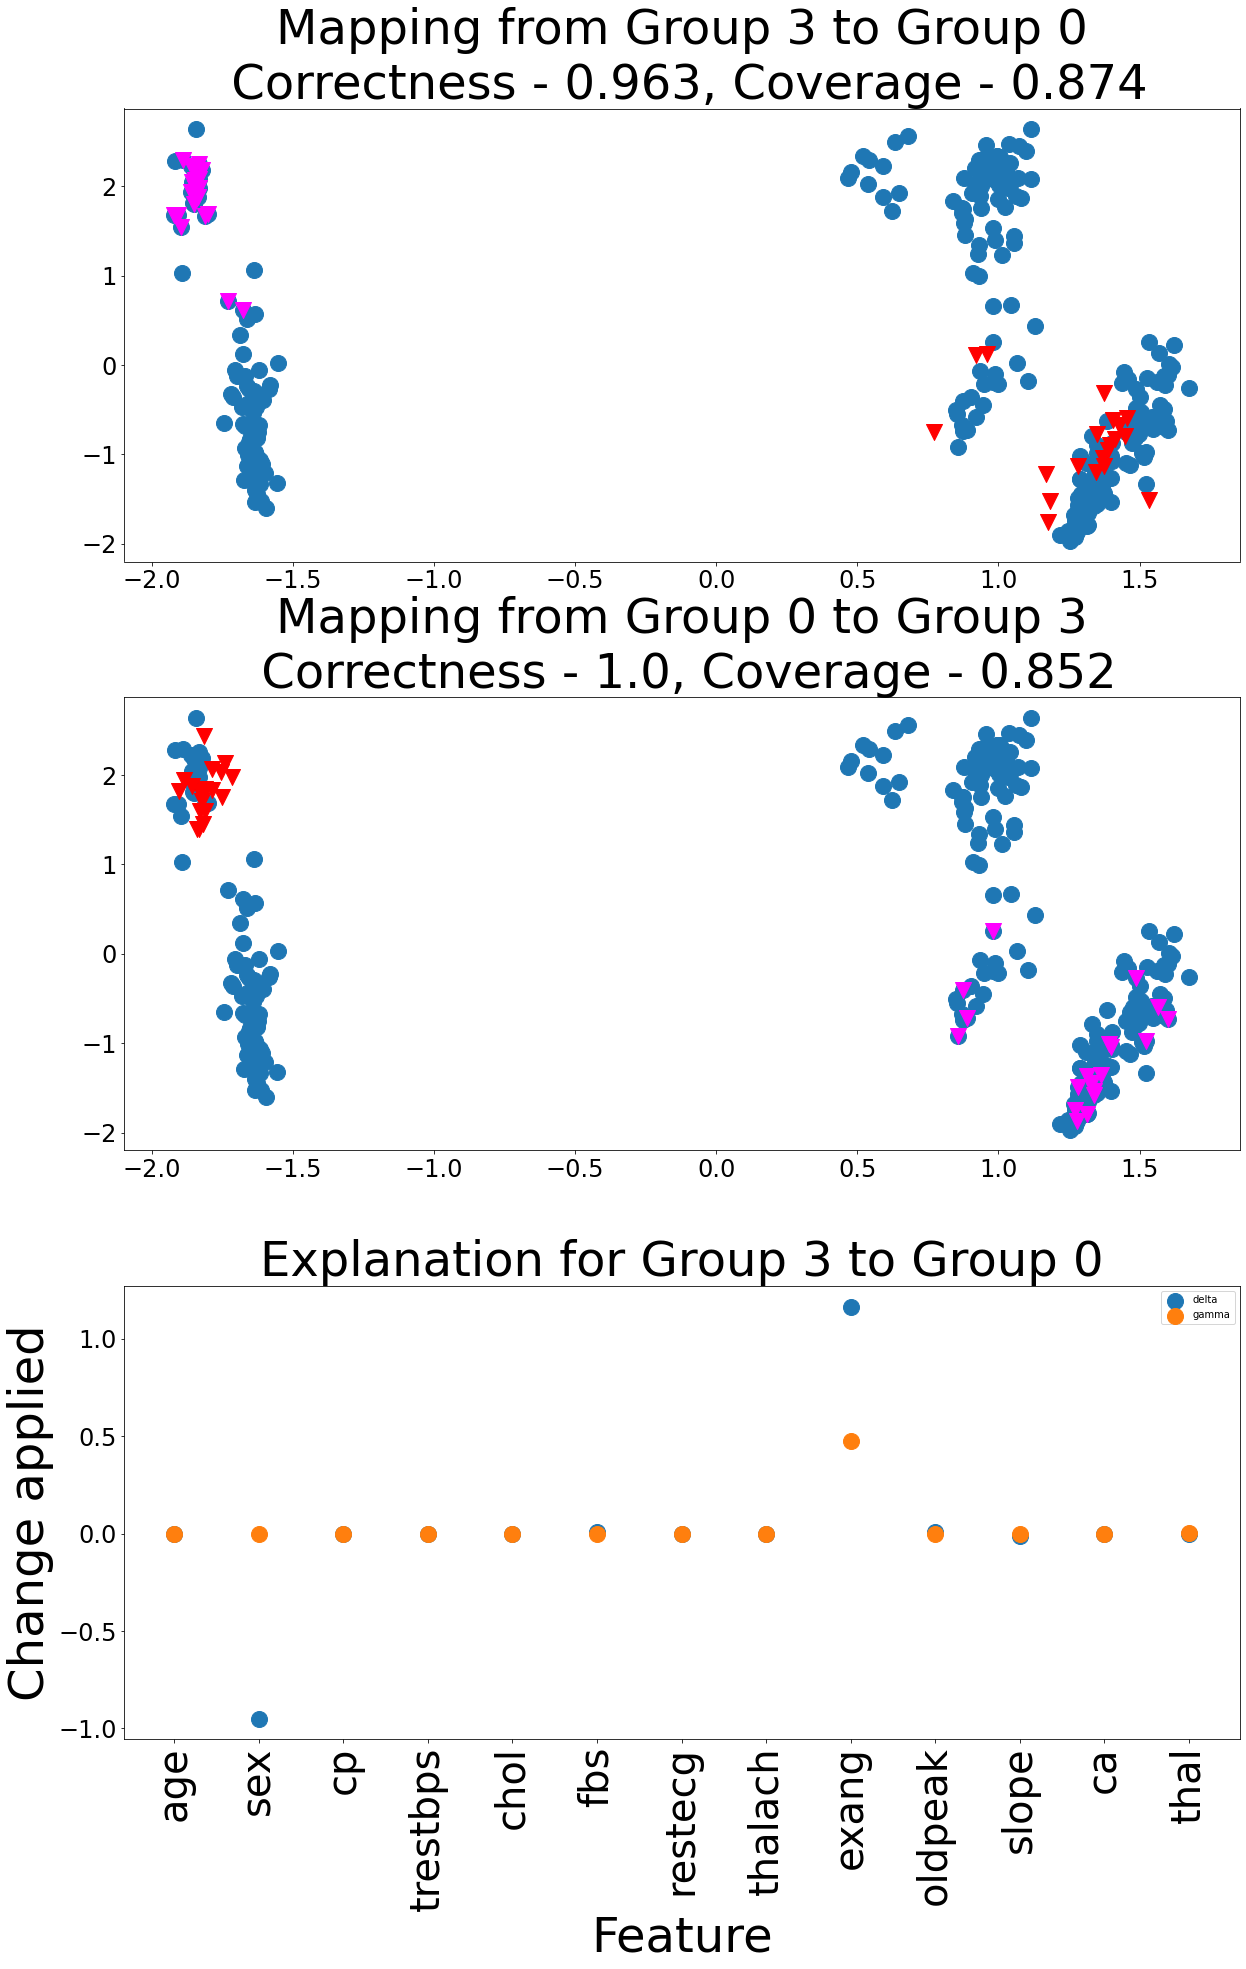

In [12]:
# Evaluate the explanations
# from eldr.plotter.myplot import *
k = 5
import torch
feature_names = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal"]

deltas_ = np.load(f"{results_path}deltas" + str(k) + ".npy")
logit_gammas_ = np.load(f"{results_path}logit_gammas" + str(k) + ".npy")
np.set_printoptions(suppress=True)
print(deltas_)
print(logit_gammas_)

a, b = Explainer.metrics(torch.tensor(x), indices, torch.from_numpy(deltas_), epsilon, k = k, logit_gammas=torch.from_numpy(logit_gammas_))

plot_metrics(a, b, name = "heartscaling-metrics.png")

plot_explanation(model, x, data_rep, indices, deltas_, a, b, 0, 1, k = k, num_points = 20, name = "heartscaling-0to1.png", feature_names = feature_names, logit_gammas=logit_gammas_)

plot_explanation(model, x, data_rep, indices, deltas_, a, b, 1, 2, k = k,  num_points = 20, name = "heartscaling-1to2.png", feature_names = feature_names, logit_gammas=logit_gammas_)

plot_explanation(model, x, data_rep, indices, deltas_, a, b, 2, 3, k = k,  num_points = 20, name = "heartscaling-2to3.png", feature_names = feature_names, logit_gammas=logit_gammas_)
plot_explanation(model, x, data_rep, indices, deltas_, a, b, 3, 0, k = k,  num_points = 20, name = "heartscaling-3to4.png", feature_names = feature_names, logit_gammas=logit_gammas_)


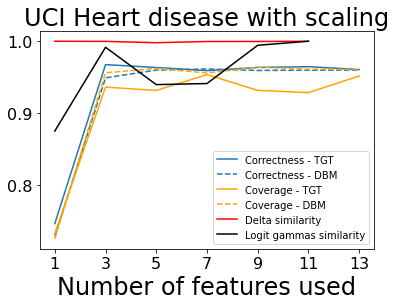

In [13]:
from eldr.misc import load
import matplotlib
matplotlib.rc("xtick", labelsize = 16)
matplotlib.rc("ytick", labelsize = 16)
matplotlib.rc("axes", titlesize = 24)
matplotlib.rc("axes", labelsize = 24)
out_path = f'{base_path}experiments/Heart/out.csv'
out = np.loadtxt(out_path, delimiter=",")
S_deltas = np.zeros(len(K) - 1)
S_gammas = np.zeros(len(K) - 1)
S_range = []
for c in range(len(K) - 1):
    k_more = K[c]
    k_less = K[c + 1]
    
    d_more = np.load(f"{results_path}deltas" + str(k_more) + ".npy")
    d_less = np.load(f"{results_path}deltas" + str(k_less) + ".npy")
    g_more = np.load(f"{results_path}logit_gammas" + str(k_more) + ".npy")
    g_less = np.load(f"{results_path}logit_gammas" + str(k_less) + ".npy")
    
    res_deltas = np.ones((num_clusters, num_clusters))
    res_gammas = np.ones((num_clusters, num_clusters))
    
    for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j:
                e_d_more = load(d_more, k_more, i, j).numpy()
                e_d_less = load(d_less, k_less, i, j).numpy()
                e_g_more = load(g_more, k_more, i, j).numpy()
                e_g_less = load(g_less, k_less, i, j).numpy()
                
                res_deltas[i,j] = Explainer.similarity(e_d_more, e_d_less)
                res_gammas[i,j] = Explainer.similarity(e_g_more, e_g_less)
    S_deltas[c] = np.mean(res_deltas)
    S_gammas[c] = np.mean(res_gammas)
    S_range.append(k_more)

plt.plot(out[:, 0], out[:, 1], c = "C0", label = "Correctness - TGT")
plt.plot(out[:, 0], out[:, 3], ls = "--", c= "C0", label = "Correctness - DBM")
plt.plot(out[:, 0], out[:, 2], c = "orange", label = "Coverage - TGT")
plt.plot(out[:, 0], out[:, 4], ls = "--", color = "orange", label = "Coverage - DBM")
plt.plot(S_range, S_deltas, c = 'red', label='Delta similarity')
plt.plot(S_range, S_gammas, c = 'black', label='Logit gammas similarity')

plt.xlabel('Number of features used')
plt.title('UCI Heart disease with scaling')
plt.xticks(np.arange(1, 15, step=2))
plt.legend()

plt.savefig("heartscaling-tradeoff.png", bbox_inches='tight')
plt.show()
plt.close()